## Train bag-of-words classifier

Train a bag-of-words classifier (Multinomial Naive Bayes), as for spam/ham filters, as first pass at distinguishing between highlighted and non-highlighted sentences.

This is unlikely to be very accurate, since highlighted sentences seem to be more similar in writing style to the sentences around them than spam e-mail text is to normal e-mail text.

In [2]:
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob, Word
import pandas as pd
import sklearn
import pickle
import numpy as np
import nltk.data
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve, GridSearchCV, StratifiedKFold, cross_val_score, train_test_split 
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

### Retrieve dict_all with pickle


In [3]:
dict_all = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dict_all','rb'))
data = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/data_pd','rb'))
sent_all = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/sent_all','rb'))

In [4]:
print(len(sent_all))

238462


In [6]:
# Tokenize highlights into sentences
n = 0
high_all = []
high_mat = []
for i in data['ids']:
    high = tokenizer.tokenize(data['highlights'][n])
    for j in high: 
        high_all.append(j)    # collect all sentences from all highlights into one list
        high_mat.append([i, j, 'hl'])
    n += 1
print(len(high_all))
print(len(high_mat))
print(high_mat[0])


5211
5211
['2', 'Until you appreciate what you currently have, more won’t make your life better.', 'hl']


In [7]:
n = 0
sent_tmp = []
sent_mat = []
for i in data['ids']:
    full = str(' '.join(data['text'][n]))
    high = data['highlights'][n]
    fnoh = full.replace(high,' ')

    sent = tokenizer.tokenize(fnoh)
    for j in sent: 
        sent_tmp.append(j)    # collect all sentences from all full texts into one list
        sent_mat.append([i, j, 'no'])
    n+=1

print(len(sent_tmp))
print(len(sent_mat))
print(sent_mat[0])
sent_tmp == sent_all


238412
238412
['2', 'When you have five minutes of down-time, how do you spend that time?', 'no']


False

### Put highlight sentences and fulltext sentences in one pandas dataframe with label, HL or NO



In [8]:
allbag = high_mat + sent_mat
# print(allbag[6002:6005])

d_allbag = pd.DataFrame({'ids':[i[0] for i in allbag], 'sentence':[i[1] for i in allbag], 'tag':[i[2] for i in allbag]})
d_allbag.groupby('tag').describe()

# NOTE: what's up with non-unique sentences within tags? are there really ~40 sentences the same between all
#       highlights among all articles? Look into this?


ids sentence
tag                        
hl  count     5211     5211
    unique    3201     5174
    top       2874        .
    freq        16        7
no  count   238412   238412
    unique    3186   227818
    top       2005        .
    freq       707      211

### CHECK FOR DUPLICATES in sentences



In [32]:
seen = set()
seen_add = seen.add

text_unq = []
id_unq = []    # store ids of first unique highlights
id_non = []    # store ids of non-unique highlights
idnum = 0

for x in d_allbag['sentence']:    # get unique highlights, preserving order
    if x in seen:
        id_non.append(d_allbag['ids'][idnum])
        idnum += 1
        continue
    seen_add(x)
    text_unq.append(x)
    id_unq.append(d_allbag['ids'][idnum])
    idnum += 1
    if idnum == 5210:
        break

print(id_unq[49])    # check that id_hl_uniq matches htext_uniq -- it does!!
print(text_unq[49])
print(len(id_unq))
print(len(text_unq))

40
We are all apprentices in a craft where no one ever becomes a master.
5173
5173


### Calculate lengths



In [ ]:
d_allbag['length'] = d_allbag['sentence'].map(lambda text: len(text))
print(d_allbag.head())


### Visualize distribution of lengths



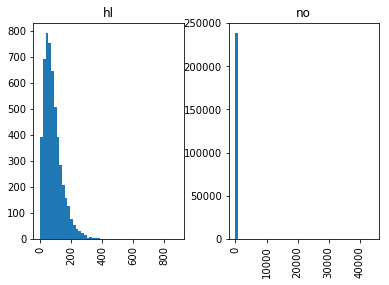

In [10]:
plot = d_allbag.hist(column='length', by='tag', bins=50)#, xlim=[0, 800], ylim=[0,800])
# plt.set_xlim((0,800))
# plot[0][1].set_xlim((0,800))
plt.show()

### Tokenize into words



In [11]:
def tokenize_words(txt):
    txt = txt.lower()  # convert bytes into proper unicode
    return TextBlob(txt).words

def split_into_lemmas(sent):
    sent = sent.lower()
    words = TextBlob(sent).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]


# d_allbag2 = d_allbag.copy()
# print(d_allbag.head())

print(d_allbag.sentence.head().apply(split_into_lemmas))
# print(d_allbag.sentence.head().apply(tokenize_words))
d_allbag.sentence.apply(split_into_lemmas)



0    [until, you, appreciate, what, you, currently,...
1    [and, let, ’, s, not, feel, terrified, but, fu...
2    [hard, work, is, doing, the, work, other, peop...
3    [he, ’, d, made, up, his, mind, to, skip, the,...
4    [realizing, that, our, action, feeling, and, b...
Name: sentence, dtype: object


0         [until, you, appreciate, what, you, currently,...
1         [and, let, ’, s, not, feel, terrified, but, fu...
2         [hard, work, is, doing, the, work, other, peop...
3         [he, ’, d, made, up, his, mind, to, skip, the,...
4         [realizing, that, our, action, feeling, and, b...
5         [so, the, advice, i, have, is, to, find, what,...
6                    [what, your, financial, ambition, are]
7                        [what, your, life, challenge, are]
8         [the, problem, that, you, want, to, try, and, ...
9         [the, mountain, that, you, want, to, climb, wh...
10               [you, can, ’, t, listen, to, anyone, else]
11        [you, need, to, listen, to, yourself, and, do,...
12        [cryptoeconomic, approach, combine, cryptograp...
13        [you, can, feel, however, you, want, about, du...
14        [he, very, well, might, win, four, consecutive...
15        [but, there, ’, s, no, denying, the, pure, spl...
16        [a, good, principle, should, b

### Save



In [12]:
# f_allbag = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/d_allbag','wb')
# pickle.dump(d_allbag, f_allbag)


### Vectorize

In [13]:
print('test')
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(d_allbag['sentence'])
# count vectorizer performed on lemmas, fit to all sentences
print(len(bow_transformer.vocabulary_))


test
82918


### Explore vectorized data

In [22]:
test10 = d_allbag['sentence'][9]
print(test10)

bow10 = bow_transformer.transform([test10])  
print(bow10)
print(bow10.shape)

print( bow_transformer.get_feature_names()[80731] ) # what appears twice?

sents_bow = bow_transformer.transform(d_allbag['sentence'])
print( 'sparse matrix shape:', sents_bow.shape)
print( 'number of non-zeros:', sents_bow.nnz)
print( 'sparsity: %.2f%%' % (100.0 * sents_bow.nnz / (sents_bow.shape[0] * sents_bow.shape[1])))

The mountains that you want to climb while you’re here.
  (0, 15493)	1
  (0, 34330)	1
  (0, 47630)	1
  (0, 59335)	1
  (0, 72144)	1
  (0, 72166)	1
  (0, 73095)	1
  (0, 78283)	1
  (0, 79137)	1
  (0, 80731)	2
  (0, 82553)	1
(1, 82918)
you
sparse matrix shape: (243623, 82918)
number of non-zeros: 3824033
sparsity: 0.02%


# Apply TF-IDF transformation



In [25]:
tfidf_transformer = TfidfTransformer().fit(sents_bow)
tfidf10 = tfidf_transformer.transform(bow10)
print(tfidf10)

print( tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print( tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])
print( tfidf_transformer.idf_[bow_transformer.vocabulary_['you']])

  (0, 82553)	0.125820036863
  (0, 80731)	0.308799103692
  (0, 79137)	0.306853179723
  (0, 78283)	0.267032289544
  (0, 73095)	0.116899882943
  (0, 72166)	0.107247239777
  (0, 72144)	0.151781857868
  (0, 59335)	0.249793466847
  (0, 47630)	0.49475037811
  (0, 34330)	0.286645393836
  (0, 15493)	0.534604278266
4.90700328043
7.07902236975
2.63191132802


In [27]:
sents_tfidf = tfidf_transformer.transform(sents_bow)
print( sents_tfidf.shape)

(243623, 82918)


### TRY OUT TRAINING MODEL
Just train model on the full dataset for now, split into test/train/validation sets later


In [44]:
%time highlighter = MultinomialNB().fit(sents_tfidf, d_allbag['tag'])

CPU times: user 757 ms, sys: 31.6 ms, total: 789 ms
Wall time: 806 ms


predicted: no
expected: hl
['no' 'no' 'no' ..., 'no' 'no' 'no']
accuracy 0.977272260829
confusion matrix
 [[     4   5207]
 [   330 238082]]
(row=expected, col=predicted)


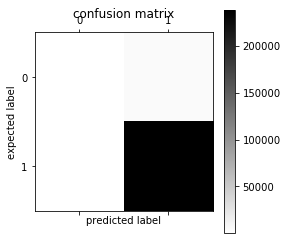

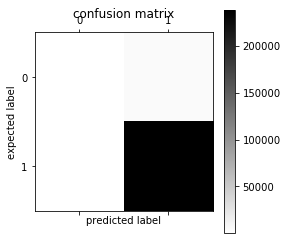

In [50]:
print( 'predicted:', highlighter.predict(tfidf10)[0])
print( 'expected:', d_allbag.tag[9])

all_predictions = highlighter.predict(sents_tfidf)
print( all_predictions)

print( 'accuracy', accuracy_score(d_allbag['tag'], all_predictions))
print( 'confusion matrix\n', confusion_matrix(d_allbag['tag'], all_predictions))
print( '(row=expected, col=predicted)')

plt.matshow(confusion_matrix(d_allbag['tag'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [52]:
print( classification_report(d_allbag['tag'], all_predictions))


             precision    recall  f1-score   support

         hl       0.01      0.00      0.00      5211
         no       0.98      1.00      0.99    238412

avg / total       0.96      0.98      0.97    243623



### SPLIT INTO TRAINING, TEST, HOLDOUT SETS


In [35]:
sent_train, sent_test, tag_train, tag_test = \
    train_test_split(d_allbag['sentence'], d_allbag['tag'], test_size=0.2)

print( len(sent_train), len(sent_test), len(sent_train) + len(sent_test))

194898 48725 243623


In [43]:
print(tag_test.head())
print(sent_test.head())
len(tag_test.tag[0])
# print(tag_test.count('hl'))
# print(tag_train.count('hl'))
# print(tag_test.count('no'))
# print(tag_train.count('no'))


132650    no
158030    no
81619     no
143376    no
63394     no
Name: tag, dtype: object
132650    I got really good at rebuilding my identity fr...
158030    If you only followed FOX, NPR, CNBC, or Reuter...
81619     There is too much focus in Silicon Valley on t...
143376    Rayovac eventually brought out something almos...
63394                                      How can this be?
Name: sentence, dtype: object


AttributeError: 'Series' object has no attribute 'tag'